# Quantify the reference search pipeline 

In [1]:
## calculate the total number of paragraphs GPT-4 generated and the number of paragraphs that contain citations

import pandas as pd
import json
import re
FilePath = './data/CH_omics_revamped_LLM_Enrichr_simVals_failure_refs_newThresh_DF.tsv'

df = pd.read_csv(FilePath, sep='\t')
print(df.shape)
with open ('./data/omics_paragraph_keywords_dict.json', 'r') as json_file:
    para_keyword_dict = json.load(json_file)

(300, 27)


In [2]:
#if there is NA in referenced analysis
df[df['referenced_analysis'].isna()]

,GeneSetName,Unnamed: 0.1,...1,...2,Unnamed: 0,Source,GeneSetID,GeneList,n_Genes,LLM Name,...,Term,GO term,GO ID,GO_term_genes,LLM_name_GO_term_sim,enrichr_JI,LLM_success_TF,enrichr_success_TF,referenced_analysis,enrichr_success_TF_0.1


In [3]:
# Function to find keywords for a specific paragraph
def find_keywords_for_paragraph(paragraph_id, paragraph_text, data_dict):
    # Check if the paragraph_id exists in the dictionary
    if paragraph_id in data_dict:
        for paragraph_info in data_dict[paragraph_id]:
            # Compare each paragraph text to the target paragraph text
            if paragraph_info.get("paragraph") == paragraph_text:
                # Return the keywords if a match is found
                return paragraph_info.get("keywords")
    # Return None if the paragraph_id or paragraph text is not found
    return None


total_paragraphs = 0
cited_paragraphs = 0
paragraphs_no_keywords = 0
num_citations_per_paragraph = []
for i, row in df.iterrows():
    
    set_name = row['GeneSetName']

    ref_text = row['referenced_analysis']
    if not pd.isna(ref_text):
        # split the input text into paragraphs
        paragraphs, references = ref_text.split('='*200)
        paragraphs =  list(filter(lambda p: len(p.split()) > 5, paragraphs.split("\n\n")))
        
        citation_indices = [re.findall(r'\[(\d+)\]', paragraph) for paragraph in paragraphs]
        num_citations = [len(citations) for citations in citation_indices]
        num_citations_per_paragraph.extend(num_citations)
        num_paragraphs = len(paragraphs)
        # total number of paragraphs from gpt responses
        total_paragraphs += num_paragraphs
        # count the number of paragraphs that contain citations
        num_cited_paragraphs = sum([1 for num_citation in num_citations if num_citation > 0])
        cited_paragraphs += num_cited_paragraphs
        print(f'{set_name}: {num_cited_paragraphs} out of {num_paragraphs} paragraphs contain citations')

        # remove the citation indices from the paragraphs
        clean_paragraphs = [re.sub(r'\[\d+\]', '', paragraph) for paragraph in paragraphs]
        for p in clean_paragraphs:
            if not find_keywords_for_paragraph(set_name, p, para_keyword_dict):
                paragraphs_no_keywords += 1
            # print(p)
            # print(para_ref_dict[p])
            # print('-'*100) 
        print(paragraphs_no_keywords)
        
with open ('data/num_citations_per_paragraph.json', 'w') as f:
    json.dump(num_citations_per_paragraph, f)

BRD-A00546892 -666 MCF7 6.0 h 10.0 um: 8 out of 10 paragraphs contain citations
1
BRD-A00993607 ALPRENOLOL MCF7 6.0 h 10.0 um: 9 out of 10 paragraphs contain citations
2
BRD-A00993607 Alprenolol hydrochloride MCF7 6.0 h 10.0 um: 6 out of 8 paragraphs contain citations
4
BRD-A01320529 Salmeterol MCF7 6.0 h 10.0 um: 9 out of 10 paragraphs contain citations
5
BRD-A01346607 FLUMETHASONE MCF7 6.0 h 10.0 um: 12 out of 17 paragraphs contain citations
8
BRD-A01593789 CHLORMADINONE ACETATE MCF7 6.0 h 10.0 um: 9 out of 11 paragraphs contain citations
10
BRD-A02006392 NITRENDIPINE MCF7 6.0 h 10.0 um: 7 out of 9 paragraphs contain citations
12
BRD-A02176148 TUBAIC ACID MCF7 6.0 h 10.0 um: 12 out of 13 paragraphs contain citations
13
BRD-A02367930 ETHINYL ESTRADIOL MCF7 6.0 h 10.0 um: 6 out of 8 paragraphs contain citations
15
BRD-A02710418 Meptazinol hydrochloride MCF7 6.0 h 10.0 um: 6 out of 9 paragraphs contain citations
17
BRD-A02759312 Betaxolol hydrochloride MCF7 6.0 h 10.0 um: 6 out of 9 par

In [4]:
print(f'Total number of paragraphs: {total_paragraphs}')
print(f'Number of paragraphs that does not have keywords combination: {paragraphs_no_keywords}')
print(f'Total number of searched paragraphs: {total_paragraphs - paragraphs_no_keywords}')
print(f'Percentage of non searched paragraphs: {paragraphs_no_keywords/total_paragraphs*100: .2f}%')
print(f'Number of paragraphs that contain references: {cited_paragraphs}')
print(f'Percentage of paragraphs that contain references: {(cited_paragraphs/total_paragraphs)*100: .2f}%')
print(f'Percentage of searched paragraphs that contain references: {(cited_paragraphs/(total_paragraphs - paragraphs_no_keywords))*100: .2f}%')

Total number of paragraphs: 3013
Number of paragraphs that does not have keywords combination: 497
Total number of searched paragraphs: 2516
Percentage of non searched paragraphs:  16.50%
Number of paragraphs that contain references: 2299
Percentage of paragraphs that contain references:  76.30%
Percentage of searched paragraphs that contain references:  91.38%


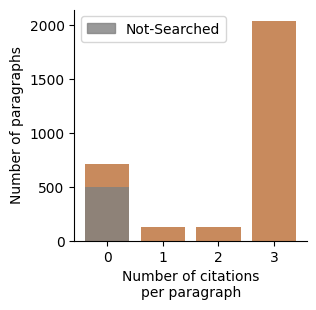

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import json 

with open ('data/num_citations_per_paragraph.json') as json_file:
    num_citations_per_paragraph = json.load(json_file)
num_citations_per_paragraph_df = pd.DataFrame(num_citations_per_paragraph, columns=['Citations'])
# Convert 'Citations' column to categorical type and define all possible categories
num_citations_per_paragraph_df['Citations'] = pd.Categorical(num_citations_per_paragraph_df['Citations'], categories=[0, 1, 2, 3])

# # create the plot
# sns.set_context("paper", font_scale=2)
# plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(3,3))
plt.rcParams['svg.fonttype'] = 'none'
sns.countplot(data=num_citations_per_paragraph_df, x='Citations', ax=ax, color='chocolate', alpha=0.8)

ax.bar(x=0, height=paragraphs_no_keywords, color='grey', alpha=0.8)
sns.despine()
# Create a custom legend for the non-searched bar
legend_patch = mpatches.Patch(color='grey', alpha=0.8, label='Not-Searched')

# Add the legend to the plot
ax.legend(handles=[legend_patch], loc='upper left')

ax.set_xlabel('Number of citations\nper paragraph')
ax.set_ylabel('Number of paragraphs')
plt.savefig('figures/num_citations_per_paragraph.svg', dpi = 300, bbox_inches='tight')
plt.show()



In [40]:
num_citations_per_paragraph_df['Citations'].value_counts()

3    2004
0     700
1     126
2     122
Name: Citations, dtype: int64